In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir      = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir       = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val   = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test  = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Information about the "flow_from_directory" function's parameters in Keras, key points to remember, and usage examples:

Key Parameters:

- directory: The path to the root directory containing the subdirectories of images for each class.
- target_size: The desired size (height, width) to resize the images to.
- color_mode: Specifies the image format (e.g., 'rgb' for color images, 'grayscale' for grayscale).
- classes: Optional list of class names (inferred from subdirectory names if not provided).
- class_mode: Specifies how to represent the labels (e.g., 'categorical' for one-hot encoded labels, 'binary' for binary labels).
- batch_size: The number of images to include in each batch.
- shuffle: Boolean indicating whether to shuffle the images before each epoch (True by default).
- seed: Optional integer seed for shuffling reproducibility.
- subset: Optional string to specify a subset of data for training or validation ('training' or 'validation').
- validation_split: Optional float between 0 and 1 to split a fraction of images for validation.

In [3]:
# 3
# rescale bwtween 0 and 1; working with images, consider using ImageDataGenerator from Keras: typically 1./255, to rescale pixel values from [0, 255] to [0, 1].
# Use formula like this for rescailing
# class_mode = 'binary' cuz has cats and dogs 2 classes
# test not labeled that's why I have to add classes to pass in
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen  = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=validation_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(directory=PATH,
                                                         classes=['test'],
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         batch_size=batch_size,
                                                         shuffle=False,)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


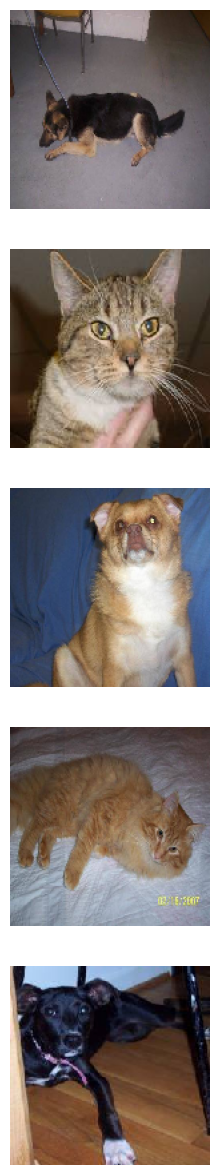

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Here's a conclusion of the key parameters within ImageDataGenerator that can help prevent overfitting by creating more training data through random transformations:

Essential Data Augmentation Parameters:

- rotation_range: Specifies a degree range for randomly rotating images (e.g., 40 for rotations up to 40 degrees).
-width_shift_range, height_shift_range: Indicate a fraction of total width or height for random horizontal and vertical shifts (e.g., 0.2 for shifts up to 20% of image dimensions).
- shear_range: Sets a shear intensity in radians for random shearing transformations.
- zoom_range: Controls a range for random zoom (e.g., 0.2 for zoom up to 20% in or out).
- horizontal_flip, vertical_flip: Boolean flags to enable random horizontal or vertical flipping of images.
- fill_mode: Determines how newly created pixels are filled after transformations (e.g., 'nearest', 'constant', 'reflect').
Additional Considerations:

- rescale: Normalize pixel values (e.g., 1./255 for conversion to a 0-1 range).
- target_size: Resize images to a consistent size for model input.
- batch_size: Use smaller batch sizes (e.g., 32 or 64) to further reduce overfitting risk.
- validation_split: Float between 0 and 1 to split a fraction of images for validation within flow_from_directory.

In [11]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=45,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           vertical_flip=True,
                                           validation_split=0.2)

Found 2000 images belonging to 2 classes.


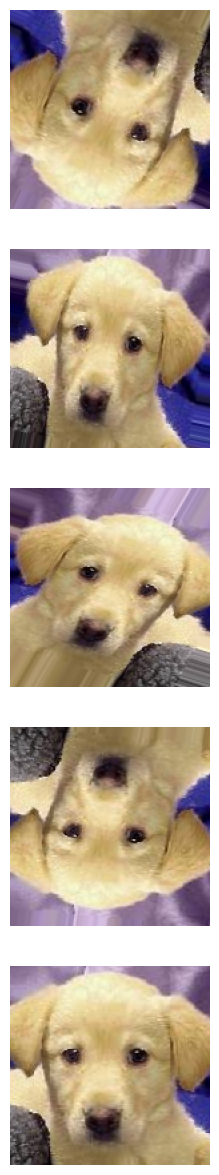

In [12]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [13]:
# 7
# Create the model
model = Sequential([
    # Convolutional layers with ReLU activation
    # Conv2D for convolutional layers.
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Adjust input_shape as needed
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the output of the convolutional layers
    Flatten(), # to convert 2D feature maps into a 1D vector.

    # Fully connected layer with ReLU activation
    Dense(64),

    # Output layer with softmax activation for class probabilities
    Dense(2)  # num_classes is the number of output classes
])

# Compile the model with appropriate optimizer and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [14]:
# 8
# Train the model, monitoring validation performance
history = model.fit(
    x=train_data_gen,  # Data generator for training data
    steps_per_epoch=len(train_data_gen),  # Number of batches per epoch
    epochs=epochs,                        # Number of training epochs
    validation_data=val_data_gen,         # Data generator for validation data
    validation_steps=len(val_data_gen)    # Number of batches for validation
)

Epoch 1/15
16/16 [==============================] - 65s 4s/step - loss: 1.2939 - accuracy: 0.5190 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 2/15
16/16 [==============================] - 64s 4s/step - loss: 0.6909 - accuracy: 0.5235 - val_loss: 0.6806 - val_accuracy: 0.5860
Epoch 3/15
16/16 [==============================] - 66s 4s/step - loss: 0.6748 - accuracy: 0.5855 - val_loss: 0.6631 - val_accuracy: 0.6240
Epoch 4/15
16/16 [==============================] - 65s 4s/step - loss: 0.6575 - accuracy: 0.6130 - val_loss: 0.6622 - val_accuracy: 0.6050
Epoch 5/15
16/16 [==============================] - 65s 4s/step - loss: 0.6587 - accuracy: 0.6015 - val_loss: 0.6580 - val_accuracy: 0.6180
Epoch 6/15
16/16 [==============================] - 65s 4s/step - loss: 0.6521 - accuracy: 0.6385 - val_loss: 0.6192 - val_accuracy: 0.6760
Epoch 7/15
16/16 [==============================] - 65s 4s/step - loss: 0.6440 - accuracy: 0.6190 - val_loss: 0.6554 - val_accuracy: 0.6070
Epoch 8/15
16/16 [==

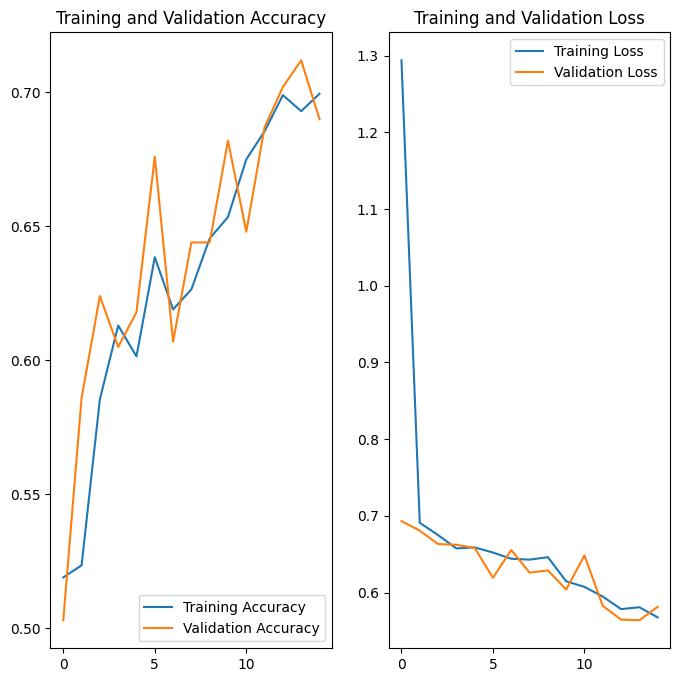

In [15]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# Get a batch of test images from the generator
test_images, _ = next(test_data_gen)

# Generate predictions for the test images
probabilities = np.argmax(model.predict(test_data_gen), axis=-1)
plotImages(test_images, probabilities=probabilities)

Output hidden; open in https://colab.research.google.com to view.

In [22]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 64.0% of the images of cats and dogs.
You passed the challenge!
